In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ast
import xarray as xr
import matplotlib.pyplot as plt
from src.data_generator import *
from src.train import *
from src.utils import *
from src.clr import *

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]=str(1)
# limit_mem()

In [4]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

## EDA

In [3]:
args = load_args('../nn_configs/B/81-resnet_d3_dr_0.1.yml')

In [4]:
ds = xr.merge(
    [xr.open_mfdataset(f'{args["datadir"]}/{var}/*.nc', combine='by_coords')
     for var in args["var_dict"].keys()],
    fill_value=0  # For the 'tisr' NaNs
)

In [5]:
ds_train = ds.sel(time=slice('2015', '2015'))

In [6]:
args['data_subsample']=24

In [76]:
dg_train = DataGenerator(
    ds_train, args['var_dict'], 24*61, batch_size=args['batch_size'], output_vars=args['output_vars'],
    data_subsample=args['data_subsample'], norm_subsample=10, nt_in=1, dt_in=1, y_nt=30*24, shuffle=False
)

In [77]:
X, y = dg_train[0]

In [78]:
y.shape

(32, 32, 64, 2)

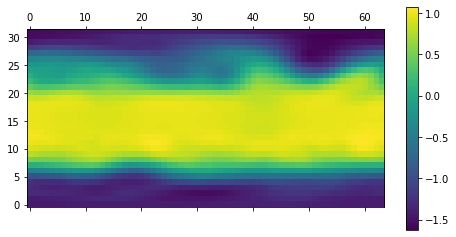

In [79]:
plt.matshow(y[0, ..., 0], origin='lower')
plt.colorbar()

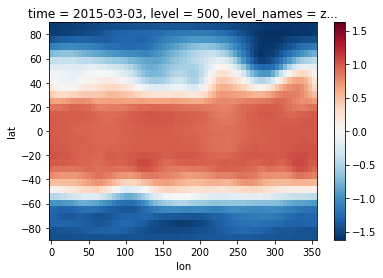

In [70]:
dg_train.data.rolling(time=30).mean().isel(time=61, level=2).plot()

In [17]:
dg_train.data.time

<xarray.DataArray 'time' (time: 365)>
array(['2015-01-01T00:00:00.000000000', '2015-01-02T00:00:00.000000000',
       '2015-01-03T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-01-02 ... 2015-12-31
Attributes:
    long_name:  time

In [18]:
dg_train.valid_time

<xarray.DataArray 'time' (time: 304)>
array(['2015-03-03T00:00:00.000000000', '2015-03-04T00:00:00.000000000',
       '2015-03-05T00:00:00.000000000', ..., '2015-12-29T00:00:00.000000000',
       '2015-12-30T00:00:00.000000000', '2015-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2015-03-03 2015-03-04 ... 2015-12-31
Attributes:
    long_name:  time

In [19]:
aggregation = 30

In [23]:
dg_train.data.isel(time=slice(30, 30+aggregation))

<xarray.DataArray 'z' (time: 30, lat: 32, lon: 64, level: 38)>
array([[[[ 0.34184724, -1.0495316 , -1.14165637, ...,  1.44426201,
           2.57085561, -1.67874412],
         [ 0.34133719, -1.04895657, -1.13692611, ...,  1.44426201,
           2.63684811, -1.67874412],
         [ 0.34082714, -1.04780651, -1.13125047, ...,  1.44426201,
           2.70122081, -1.67874412],
         ...,
         [ 0.3438802 , -1.05010526, -1.14449476, ...,  1.44426201,
           2.40688572, -1.67874412],
         [ 0.34286251, -1.05010526, -1.14544014, ...,  1.44426201,
           2.47378905, -1.67874412],
         [ 0.34235488, -1.05010526, -1.14449476, ...,  1.44426201,
           2.52247395, -1.67874412]],

        [[ 0.35659527, -1.0639005 , -1.20504168, ...,  1.44426201,
           2.06275586, -1.57043805],
         [ 0.35557758, -1.06045169, -1.16909145, ...,  1.44426201,
           2.33441714, -1.57043805],
         [ 0.35608521, -1.05240538, -1.13314235, ...,  1.44426201,
           2.4794585 , -1.57043805],
         ...,
         [ 0.36829264, -1.04378404, -1.24477567, ...,  1.44426201,
           1.50808802, -1.57043805],
         [ 0.36371425, -1.0541291 , -1.24288379, ...,  1.44426201,
           1.76416741, -1.57043805],
         [ 0.36015597, -1.06160039, -1.2296395 , ...,  1.44426201,
           1.87833927, -1.57043805]],

        [[ 0.36524199, -1.08631572, -1.2797794 , ...,  1.44426201,
           2.80071523, -1.46213197],
         [ 0.36574963, -1.09436203, -1.2551827 , ...,  1.44426201,
           3.12389527, -1.46213197],
         [ 0.36982038, -1.09148825, -1.22017898, ...,  1.44426201,
           3.37895707, -1.46213197],
         ...,
         [ 0.37744942, -0.96676562, -1.12746333, ...,  1.44426201,
           0.85969458, -1.46213197],
         [ 0.36982038, -1.02136746, -1.22206861, ...,  1.44426201,
           2.03308297, -1.46213197],
         [ 0.36320662, -1.06389914, -1.27599564, ...,  1.44426201,
           2.49159806, -1.46213197]],

        ...,

        [[-1.43977982, -1.34610467, -1.13314235, ..., -0.73436932,
          -0.44150882,  1.46213197],
         [-1.53692436, -1.33633327, -1.1520634 , ..., -0.73436932,
          -0.44090151,  1.46213197],
         [-1.63813482, -1.33863202, -1.17571472, ..., -0.73436932,
          -0.44191369,  1.46213197],
         ...,
         [-1.13563597, -1.35185223, -1.13881799, ..., -0.7343693 ,
          -0.435842  ,  1.46213197],
         [-1.23786412, -1.35989855, -1.1511169 , ..., -0.73436932,
          -0.44120516,  1.46213197],
         [-1.34060232, -1.35989855, -1.13314235, ..., -0.73436932,
          -0.441104  ,  1.46213197]],

        [[-1.7118822 , -1.46910085, -1.19936492, ..., -0.73436932,
          -0.44130638,  1.57043805],
         [-1.77393219, -1.47542344, -1.21450221, ..., -0.73436932,
          -0.44069907,  1.57043805],
         [-1.83343918, -1.4909424 , -1.24572218, ..., -0.73436932,
          -0.44241978,  1.57043805],
         ...,
         [-1.51556016, -1.47484841, -1.24950706, ...,  1.06439006,
          -0.28301559,  1.57043805],
         [-1.58269618, -1.47082593, -1.20882657, ..., -0.29933311,
          -0.39848176,  1.57043805],
         [-1.64779682, -1.46795215, -1.19368927, ..., -0.73436932,
          -0.44373519,  1.57043805]],

        [[-1.75104508, -1.52025387, -1.20882544, ..., -0.73436932,
          -0.44130638,  1.67874412],
         [-1.77393219, -1.52945024, -1.21450221, ..., -0.73436932,
          -0.44110395,  1.67874412],
         [-1.79529399, -1.53864661, -1.22112435, ..., -0.73436932,
          -0.44080029,  1.67874412],
         ...,
         [-1.67475469, -1.49783865, -1.2022033 , ..., -0.73436932,
          -0.43999064,  1.67874412],
         [-1.70069487, -1.50416124, -1.2031498 , ..., -0.73436932,
          -0.44191358,  1.67874412],
         [-1.72663264, -1.51163253, -1.20504168, ..., -0.73436932,
          -0.44161007,  1.67874412]]],


       [[[ 0.29658065, -1.10068462, -1.20409518, ...,  1.44426201,
           2.5

In [32]:
a = dg_train.data.isel(time=slice(0, 30)).mean('time')
a

<xarray.DataArray 'z' (lat: 32, lon: 64, level: 38)>
array([[[ 0.37058176, -1.06706102, -1.15584724, ...,  1.44426201,
          2.57085561, -1.67874412],
        [ 0.37024285, -1.0658541 , -1.15077004, ...,  1.44426201,
          2.63684811, -1.67874412],
        [ 0.37000547, -1.06468542, -1.14556686, ...,  1.44426201,
          2.70122081, -1.67874412],
        ...,
        [ 0.3724974 , -1.06993499, -1.16852419, ...,  1.44426201,
          2.40688572, -1.67874412],
        [ 0.37164989, -1.06918754, -1.16467695, ...,  1.44426201,
          2.47378905, -1.67874412],
        [ 0.37100583, -1.06819142, -1.16041983, ...,  1.44426201,
          2.52247395, -1.67874412]],

       [[ 0.32543514, -1.07489695, -1.17063718, ...,  1.44426201,
          2.06275586, -1.57043805],
        [ 0.32536737, -1.0685363 , -1.1514638 , ...,  1.44426201,
          2.33441714, -1.57043805],
        [ 0.32570644, -1.06152449, -1.13112374, ...,  1.44426201,
          2.4794585 , -1.57043805],
        ...,
        [ 0.33009725, -1.08855701, -1.20907822, ...,  1.44426201,
          1.50808802, -1.57043805],
        [ 0.32770677, -1.08514668, -1.20024847, ...,  1.44426201,
          1.76416741, -1.57043805],
        [ 0.32606219, -1.0803763 , -1.18741392, ...,  1.44426201,
          1.87833927, -1.57043805]],

       [[ 0.26603089, -1.10991856, -1.20901508, ...,  1.44426201,
          2.80071523, -1.46213197],
        [ 0.26740376, -1.09888327, -1.17669176, ...,  1.44426201,
          3.12389527, -1.46213197],
        [ 0.27040445, -1.08700507, -1.14692288, ...,  1.44426201,
          3.37895707, -1.46213197],
        ...,
        [ 0.27152327, -1.12877046, -1.24382958, ...,  1.44426201,
          0.85969458, -1.46213197],
        [ 0.2675733 , -1.12539868, -1.24461815, ...,  1.44426201,
          2.03308297, -1.46213197],
        [ 0.26592864, -1.11967042, -1.23462187, ...,  1.44426201,
          2.49159806, -1.46213197]],

       ...,

       [[-1.27523223, -1.04594843, -0.96411456, ..., -0.73436932,
         -0.44150882,  1.46213197],
        [-1.28386155, -1.03244171, -0.93737291, ..., -0.73436932,
         -0.44090151,  1.46213197],
        [-1.30147626, -1.03269094, -0.92636721, ..., -0.73436932,
         -0.44191369,  1.46213197],
        ...,
        [-1.28981233, -1.13051494, -1.05071016, ..., -0.7343693 ,
         -0.435842  ,  1.46213197],
        [-1.27821575, -1.09725557, -1.02412637, ..., -0.73436932,
         -0.44120516,  1.46213197],
        [-1.27396048, -1.0684029 , -0.99738479, ..., -0.73436932,
         -0.441104  ,  1.46213197]],

       [[-1.47263731, -1.09238863, -0.95490639, ..., -0.73436932,
         -0.44130638,  1.57043805],
        [-1.48508091, -1.09323169, -0.95336123, ..., -0.73436932,
         -0.44069907,  1.57043805],
        [-1.50059344, -1.10125906, -0.95954212, ..., -0.73436932,
         -0.44241978,  1.57043805],
        ...,
        [-1.45230972, -1.12959485, -0.9989297 , ...,  1.06439006,
         -0.28301559,  1.57043805],
        [-1.45688714, -1.11122168, -0.97903111, ..., -0.29933311,
         -0.39848176,  1.57043805],
        [-1.46377028, -1.09886433, -0.96395733, ..., -0.73436932,
         -0.44373519,  1.57043805]],

       [[-1.53961975, -1.25571457, -1.11144594, ..., -0.73436932,
         -0.44130638,  1.67874412],
        [-1.54528238, -1.25923964, -1.11453642, ..., -0.73436932,
         -0.44110395,  1.67874412],
        [-1.55060555, -1.2637994 , -1.1191089 , ..., -0.73436932,
         -0.44080029,  1.67874412],
        ...,
        [-1.52239527, -1.25303233, -1.11097291, ..., -0.73436932,
         -0.43999064,  1.67874412],
        [-1.5282442 , -1.25270662, -1.10971151, ..., -0.73436932,
         -0.44191358,  1.67874412],
        [-1.53397452, -1.25360713, -1.10986929, ..., -0.73436932,
         -0.44161007,  1.67874412]]])
Coordinates:
  * lat          (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon          (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354

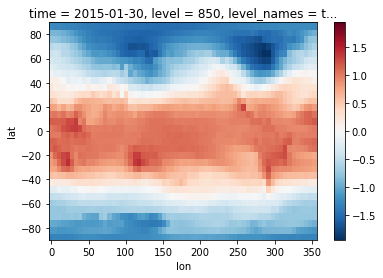

In [60]:
dg_train.data.rolling(time=30).mean().isel(time=29, level=12).plot()

In [25]:
i = 0
idxs = dg_train.idxs[i * dg_train.batch_size:(i + 1) * dg_train.batch_size]

In [28]:
nt = 70
y_nt = 30
y = dg_train.data.isel(
    time=slice(idxs + nt, idxs + nt + y_nt), 
    level=dg_train.output_idxs
)

TypeError: only integer scalar arrays can be converted to a scalar index

## Argh, create script to convert datasets to daily averages

In [81]:
datadir = '/data/stephan/WeatherBench/5.625deg/2m_temperature/'

In [83]:
ds_in = xr.open_mfdataset(f'{datadir}/*.nc', combine='by_coords')

In [84]:
ds_in

,Array,Chunk
Bytes,2.87 GB,71.96 MB
Shape,"(350640, 32, 64)","(8784, 32, 64)"
Count,120 Tasks,40 Chunks
Type,float32,numpy.ndarray


In [85]:
avg_hours = 24

In [87]:
dt = dt = ds_in.time.diff('time')[0].values / np.timedelta64(1, 'h')
dt

1.0

In [89]:
nt = int(avg_hours / dt)
nt

24

In [91]:
ds_out = ds_in.rolling(time=nt, center=False, keep_attrs=True).mean()

In [92]:
ds_out.load()

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 nan nan nan ... 250.86975 251.13763
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [110]:
save_years = 5

In [95]:
ds_out.time.dt.year.max()

<xarray.DataArray 'year' ()>
array(2018)

In [116]:
savepref = '/test/'
savesuf = '5.625deg.nc'

In [117]:
year_range = (ds_out.time.dt.year.min().values, ds_out.time.dt.year.max().values)

In [123]:
for y in range(*year_range, save_years):
    savefn = f'{savepref}{y if save_years==1 else str(y)+"_"+str(min(y+save_years, year_range[-1]))}_{savesuf}'
    print(savefn)
    ds_save = ds_out.sel(time=slice(str(y), str(y+save_years)))

/test/1979_1984_5.625deg.nc
/test/1984_1989_5.625deg.nc
/test/1989_1994_5.625deg.nc
/test/1994_1999_5.625deg.nc
/test/1999_2004_5.625deg.nc
/test/2004_2009_5.625deg.nc
/test/2009_2014_5.625deg.nc
/test/2014_2018_5.625deg.nc


In [124]:
ds_save

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 43824)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2014-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 248.75056 248.27461 ... 251.13763
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-07 07:51:20 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

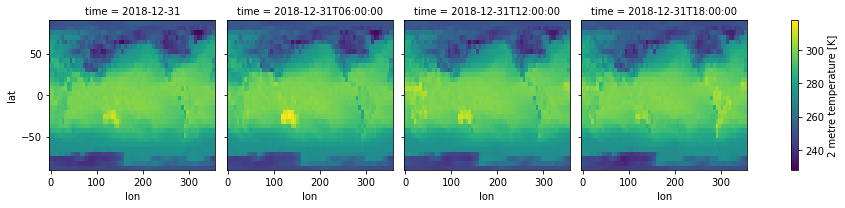

In [128]:
ds_in.t2m.isel(time=slice(-24, None, 6)).plot(col='time')

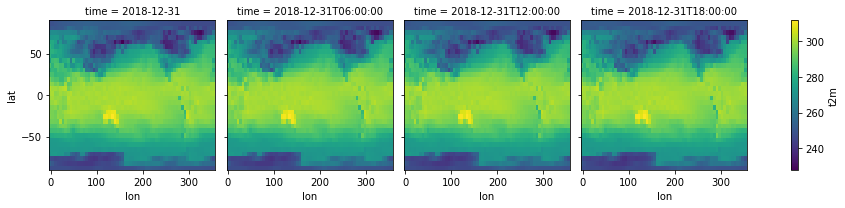

In [129]:
ds_out.t2m.isel(time=slice(-24, None, 6)).plot(col='time')

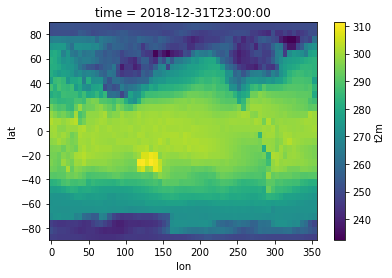

In [127]:
ds_out.t2m.isel(time=-1).plot()

## Test dg

In [5]:
%load_ext line_profiler

In [59]:
args = load_args('../nn_configs/S/001-resnet_t2m_3m.yml')

In [60]:
# args['train_years'] = ['1979', '1980']

In [86]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 17:17:17.226334
DG normalize 17:17:17.280415
DG load 17:17:30.770176
Loading data into RAM
DG done 17:18:47.617260


In [87]:
len(dg_train)

417

In [88]:
len(dg_train.idxs) / 32

416.59375

In [89]:
X, y = dg_train[0]

In [90]:
np.isnan(y).sum()

0

In [91]:
# dg_train.shuffle = True; dg_train.on_epoch_end()

In [92]:
for i, (X, y) in enumerate(dg_train):
    if np.isnan(X).sum() + np.isnan(y).sum() > 0:
        print(i)
        break

1


In [94]:
X, y = dg_train[1]

In [95]:
X.shape

(32, 32, 64, 111)

In [96]:
np.isnan(X).sum((1, 2, 3))

array([    0, 73728,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [98]:
i=1
dg_train.idxs[i * dg_train.batch_size:(i + 1) * dg_train.batch_size]

array([10818,    60, 10333,  9474, 11426, 10288,  3611,  8158,  1038,
       13149, 11222, 10168, 10238,  2670, 11515,  9355,  8882,  9711,
       10261, 12164,  7307, 11259, 12533,  8053,  5926,  7285, 12064,
        8766, 10704,   920,  8165,  3745])

## Compare 001, 003 and 004

In [99]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//001-resnet_t2m_3m.nc')

In [100]:
valid = xr.open_mfdataset(f'{args["datadir"]}/2m_temperature_daily/*.nc',combine='by_coords').isel(time=slice(0, None, 24)).load()
valid_roll = valid.rolling(time=30).mean()

In [104]:
args001 = load_args('../nn_configs/S/001-resnet_t2m_3m.yml')
args003 = load_args('../nn_configs/S/003-resnet_t2m_3m_cmip.yml')
args004 = load_args('../nn_configs/S/004-resnet_t2m_3m_pre.yml')

In [116]:
args005 = load_args('../nn_configs/S/005-resnet_t2m_3m_small.yml')
args006 = load_args('../nn_configs/S/006-unet_t2m_3m.yml')

In [105]:
dg_train, dg_valid, dg_test = load_data(**args001)

DG start 10:40:12.435231
DG normalize 10:40:12.481078
DG load 10:40:24.412878
Loading data into RAM
DG done 10:42:25.443304


In [106]:
model001 = load_model(args001)
model003 = load_model(args003)
model004 = load_model(args004)

In [117]:
model005 = load_model(args005)
model006 = load_model(args006)

In [124]:
model001.compile('adam', create_lat_mse(dg_train.data.lat))
model003.compile('adam', create_lat_mse(dg_train.data.lat))
model004.compile('adam', create_lat_mse(dg_train.data.lat))
model005.compile('adam', create_lat_mse(dg_train.data.lat))
model006.compile('adam', create_lat_mse(dg_train.data.lat))

In [125]:
model001.evaluate(dg_train)
model003.evaluate(dg_train)
model004.evaluate(dg_train)
model005.evaluate(dg_train)

416/416 [==============================] - 48s 115ms/step - loss: 0.0050


0.004982397425919771

In [126]:
model001.evaluate(dg_test)
model003.evaluate(dg_test)
model004.evaluate(dg_test)
model005.evaluate(dg_test)

17/17 [==============================] - 2s 102ms/step - loss: 0.0060


0.006008070427924395

In [129]:
dg_train.shuffle = False; dg_train.on_epoch_end()

In [114]:
preds_train004 = create_predictions(model004, dg_train)

In [115]:
compute_weighted_rmse(preds_train004, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.9754

In [130]:
preds_train005 = create_predictions(model005, dg_train)

In [131]:
compute_weighted_rmse(preds_train005, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.224

In [101]:
compute_weighted_rmse(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.445

## Score 004

In [158]:
model004.compile('adam', create_lat_rmse(dg_train.data.lat))
model005.compile('adam', create_lat_rmse(dg_train.data.lat))

In [160]:
print(model004.evaluate(dg_test))
model005.evaluate(dg_test)

17/17 [==============================] - 19s 1s/step - loss: 0.0675
0.06750791519880295
17/17 [==============================] - 3s 149ms/step - loss: 0.0675


0.06749922782182693

In [134]:
valid_roll.time

<xarray.DataArray 'time' (time: 14610)>
array(['1979-01-01T00:00:00.000000000', '1979-01-02T00:00:00.000000000',
       '1979-01-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 ... 2018-12-31
Attributes:
    long_name:  time

In [133]:
dg_test.valid_time

<xarray.DataArray 'time' (time: 518)>
array(['2017-08-01T00:00:00.000000000', '2017-08-02T00:00:00.000000000',
       '2017-08-03T00:00:00.000000000', ..., '2018-12-29T00:00:00.000000000',
       '2018-12-30T00:00:00.000000000', '2018-12-31T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2017-08-01 2017-08-02 ... 2018-12-31
Attributes:
    long_name:  time

In [138]:
y = dg_test[0][1][0].squeeze(); y.shape

(32, 64)

In [143]:
y = y * dg_test.std.isel(level=dg_test.output_idxs).values + dg_test.mean.isel(level=dg_test.output_idxs).values

In [152]:
v = valid_roll.sel(time=dg_test.valid_time[0])

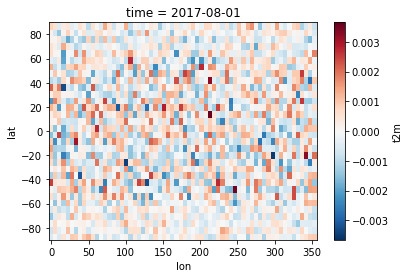

In [153]:
(v.t2m - y).plot()

In [155]:
y

array([[218.35823797, 218.13497312, 217.83553903, ..., 220.0804209 ,
        219.2546424 , 218.6445624 ],
       [226.9216263 , 225.13362968, 223.86924836, ..., 230.27239677,
        226.32558236, 225.3554774 ],
       [227.86458054, 226.90874699, 225.35790104, ..., 244.51357312,
        233.72677764, 228.65868654],
       ...,
       [277.2819061 , 278.72146607, 279.41858827, ..., 274.41435755,
        273.40315752, 275.38826509],
       [273.55392552, 273.8794262 , 273.9831524 , ..., 276.627125  ,
        273.83270363, 273.55935272],
       [273.95376676, 273.94207767, 273.942923  , ..., 273.99475824,
        273.98542174, 273.98673496]])

In [161]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//004-resnet_t2m_3m_pre.nc')

In [128]:
compute_weighted_rmse(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.434

In [162]:
compute_weighted_acc(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.9628

In [164]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//005-resnet_t2m_3m_small.nc')

In [119]:
compute_weighted_rmse(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.396

In [165]:
compute_weighted_acc(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.9635

In [128]:
compute_weighted_rmse(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.434

In [120]:
model006 = load_model(args006)

In [121]:
preds = create_predictions(model006, dg_test)

ValueError: conflicting sizes for dimension 'level': length 2 on the data but length 1 on coordinate 'level'

In [122]:
%debug

> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(155)_infer_coords_and_dims()
    153                     "conflicting sizes for dimension %r: "
    154                     "length %s on the data but length %s on "
--> 155                     "coordinate %r" % (d, sizes[d], s, k)
    156                 )
    157 

ipdb> u
> /home/rasp/miniconda3/lib/python3.7/site-packages/xarray/core/dataarray.py(344)__init__()
    342             data = _check_data_shape(data, coords, dims)
    343             data = as_compatible_data(data)
--> 344             coords, dims = _infer_coords_and_dims(data.shape, coords, dims)
    345             variable = Variable(dims, data, attrs, fastpath=True)
    346             indexes = dict(

ipdb> u
> /home/rasp/repositories/myWeatherBench/devlog/src/data_generator.py(423)create_predictions()
    421         coords={'time': dg.valid_time, 'lat': dg.data.lat, 'lon': dg.data.lon,
    422                 'level': level,
--> 423      

ipdb> preds.shape
(518, 32, 64, 2)
ipdb> level
<xarray.DataArray 'level' (level: 1)>
array([1])
Coordinates:
  * level        (level) int64 1
    level_names  (level) <U9 't2m'
ipdb> q


In [118]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//006-')

In [119]:
compute_weighted_rmse(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.396

## Load trained model

In [5]:
args = load_args('../nn_configs/S/004-resnet_t2m_3m_overfit.yml')

In [6]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 09:02:38.881302
DG load 09:02:38.923945
Loading data into RAM
DG done 09:04:48.442022
DG normalize 09:04:48.442244


In [7]:
valid = xr.open_mfdataset(f'{args["datadir"]}/2m_temperature_daily/*.nc',combine='by_coords').isel(time=slice(0, None, 24)).load()

In [8]:
valid_roll = valid.rolling(time=30).mean()

In [9]:
preds = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//004-resnet_t2m_3m_overfit.nc').load()

In [32]:
preds2 = create_predictions(model, dg_test, verbose=1)

19/19 [==============================] - 1s 64ms/step


In [51]:
compute_weighted_rmse(preds, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.592

In [12]:
model = load_model(args)

In [13]:
dg_train.shuffle = False
dg_train.on_epoch_end()

In [14]:
preds_train = create_predictions(model, dg_train, verbose=1)

419/419 [==============================] - 29s 70ms/step


In [52]:
compute_weighted_rmse(preds_train, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 0.6852

In [16]:
model.evaluate(dg_train)

419/419 [==============================] - 30s 72ms/step - loss: 0.0026


0.00260570808313787

In [17]:
model.evaluate(dg_test)

19/19 [==============================] - 1s 69ms/step - loss: 0.0122


0.012204947881400585

In [29]:
def create_monthly_climatology_forecast(ds_train, valid_time):
    monthly_averages = ds_train.groupby(ds_train.time.dt.month).mean('time')
    valid_time['month'] = valid_time['time.month']
    fc_list = []
    for t in valid_time:
        fc_list.append(monthly_averages.sel(month=t.month))
    return xr.concat(fc_list, dim=valid_time)

In [34]:
monthly_climatology = create_monthly_climatology_forecast(
    valid_roll.sel(time=slice('1979', '2015')), valid_roll.sel(time=slice('2017', '2018')).time)

In [35]:
compute_weighted_rmse(monthly_climatology, valid_roll)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.57

In [47]:
monthly_climatology = create_monthly_climatology_forecast(
    valid_roll.sel(time=slice('1981', '2000')), valid_roll.sel(time=slice('2001', '2010')).time)

In [48]:
compute_weighted_rmse(monthly_climatology, valid_roll)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 1.575

## Evaluate CMIP run

In [23]:
args = load_args('../nn_configs/S/004-resnet_t2m_3m_overfit.yml')

In [24]:
model = load_model(args)

In [25]:
args['train_years'] = ['2015', '2015']

In [26]:
args['ext_mean'] = xr.open_dataarray('/home/rasp/data/myWeatherBench/predictions_S/saved_models/004-resnet_t2m_3m_overfit_mean.nc')
args['ext_std'] = xr.open_dataarray('/home/rasp/data/myWeatherBench/predictions_S/saved_models/004-resnet_t2m_3m_overfit_std.nc')

In [27]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 14:36:12.149050
DG load 14:36:12.187457
Loading data into RAM
DG done 14:36:15.096646
DG normalize 14:36:15.096769


In [ ]:
args = load_args('../nn_configs/S/003-resnet_t2m_3m_cmip.yml')

In [6]:
args['train_years'] = ['1950', '1980']

In [7]:
args['cmip_dir'] = args['cmip_dir'][0]

In [8]:
dg_trainc, dg_validc, dg_testc = load_data(**args)

DG start 14:37:54.220834
DG load 14:37:54.264575
Loading data into RAM
DG done 14:38:17.882321
DG normalize 14:38:17.882523


In [9]:
std = dg_trainc.data.std('time')

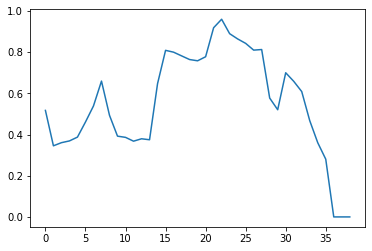

In [10]:
plt.plot(std.mean(('lat', 'lon')).values)

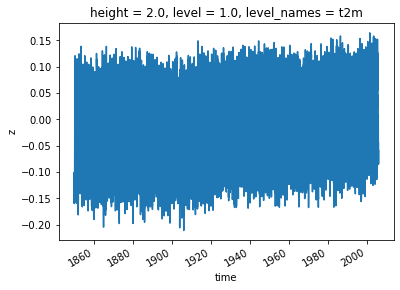

In [9]:
dg_trainc.data.isel(level=-4).mean(('lat', 'lon')).plot()

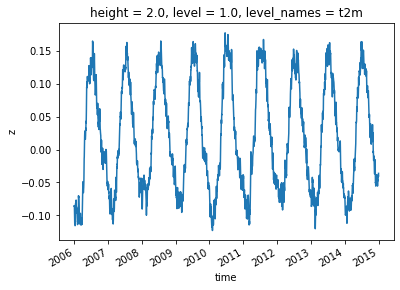

In [10]:
dg_validc.data.isel(level=-4).mean(('lat', 'lon')).plot()

In [8]:
modelc = load_model(args)

In [9]:
modelc.evaluate(dg_trainc)

 826/1777 [============>.................] - ETA: 1:47 - loss: 0.1092

KeyboardInterrupt: 

In [181]:
modelc.evaluate(dg_trainc)

1777/1777 [==============================] - 128s 72ms/step - loss: 0.1102


0.11015697568655014

In [183]:
modelc.evaluate(dg_validc)

99/99 [==============================] - 7s 68ms/step - loss: 0.0642


0.06421394646167755

In [164]:
modelc.evaluate(dg_testc)

8/8 [==============================] - 1s 65ms/step - loss: 0.0585


0.05847136303782463

In [13]:
model.evaluate(dg_trainc)

1777/1777 [==============================] - 128s 72ms/step - loss: 0.0292


0.029210679233074188

In [14]:
model.evaluate(dg_validc)

99/99 [==============================] - 7s 71ms/step - loss: 0.0190


0.018997984007000923

In [206]:
X, y = dg_trainc[0]

In [207]:
model.evaluate(X, y)

1/1 [==============================] - 0s 1ms/step - loss: 16.2582


16.2581787109375

In [208]:
X.mean(), y.mean()

(-0.05924824, -1.2799184)

In [225]:
# ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/MPI-ESM/5.625deg/2m_temperature/2m_temperature_196501010600-197001010000_5.625deg.nc').load()
ds = xr.open_dataset('/data/stephan/WeatherBench/CMIP/MPI-ESM/5.625deg/2m_temperature/2m_temperature_197001010600-197501010000_5.625deg.nc').load()

In [226]:
ds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 7304)
Coordinates:
    height   float64 2.0
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time     (time) datetime64[ns] 1970-01-01T06:00:00 ... 1975-01-01
Data variables:
    t2m      (time, lat, lon) float32 246.54626 246.2605 ... 243.95479 243.29533

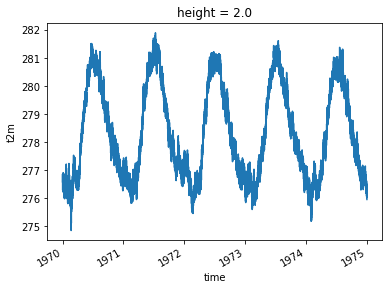

In [227]:
ds.t2m.mean(('lat', 'lon')).plot()

In [216]:
!ls *.nc

baseline_rmses.nc
bilinear_192x384_32x64_peri.nc
bilinear_64x128_32x64_peri.nc
bilinear_91x180_32x64_peri.nc
preds_cont.nc
preds_cont_fixed.nc
preds_cont_rmse.nc
rmse_cont.nc
rmse_cont_fixed.nc
rmse_cont_rmse.nc
rmse_cont_rmse2.nc
rmse_cont_train.nc
rmse_cont_valid.nc
rmse_direct.nc
rmse_direct_train.nc
rmse_direct_valid.nc
tas_6hrPlevPt_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_185001010600-185501010000.nc
tas_6hrPlevPt_MPI-ESM1-2-HR_historical_r1i1p1f1_gn_196501010600-197001010000.nc
weyn_rmse.nc


In [204]:
X, y = dg_validc[0]

In [205]:
X.mean(), y.mean()

(-0.022982314, 0.040007494)

In [186]:
model.evaluate(dg_validc)

99/99 [==============================] - 8s 79ms/step - loss: 0.0190


0.018997984007000923

In [174]:
model.evaluate(dg_testc)

8/8 [==============================] - 0s 58ms/step - loss: 0.0161


0.01611528918147087

In [165]:
predsc = create_predictions(modelc, dg_testc)

In [168]:
predsc2 = xr.open_dataset('/home/rasp/data/myWeatherBench/predictions_S//003-resnet_t2m_3m_cmip.nc').load()

In [170]:
predsc_era = create_predictions(modelc, dg_test)

In [171]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 606)
Coordinates:
  * time     (time) datetime64[ns] 2017-05-05 2017-05-06 ... 2018-12-31
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float64 221.0 220.5 219.9 ... 251.9 252.3 252.4

In [173]:
compute_weighted_rmse(predsc_era, valid_roll)

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 2.387

In [72]:
args = load_args('../nn_configs/S/004-resnet_t2m_3m_overfit.yml')

In [73]:
args['train_years'] = ['2015', '2015']

In [74]:
args['ext_mean'] = xr.open_dataarray('/home/rasp/data/myWeatherBench/predictions_S/saved_models/004-resnet_t2m_3m_overfit_mean.nc')
args['ext_std'] = xr.open_dataarray('/home/rasp/data/myWeatherBench/predictions_S/saved_models/004-resnet_t2m_3m_overfit_std.nc')

In [75]:
dg_train, dg_valid, dg_test = load_data(**args)

DG start 13:56:28.383644
DG load 13:56:28.419334
Loading data into RAM
DG done 13:56:32.036058
DG normalize 13:56:32.036172


In [152]:
dg_trainc.raw_data.isel(level=-4).mean()

<xarray.DataArray 'z' ()>
array(278.60131358)
Coordinates:
    height       float64 2.0
    level        float64 1.0
    level_names  <U9 't2m'

In [155]:
dg_train.raw_data.isel(level=34).mean()

<xarray.DataArray 'z' ()>
array(0.0061125)
Coordinates:
    level        int64 925
    level_names  <U9 'q_925'

In [ ]:
dg_train.raw

In [83]:
predsc = create_predictions(modelc, dg_testc)

In [147]:
X, y = dg_trainc[0]

In [154]:
np.argmin(X.mean((0, 1, 2)))

67

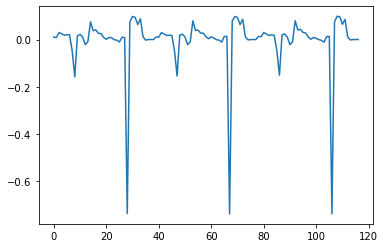

In [148]:
plt.plot(X.mean((0, 1, 2)))

In [149]:
X, y = dg_train[0]

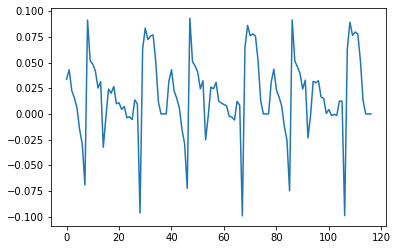

In [150]:
plt.plot(X.mean((0, 1, 2)))

In [86]:
y

array([[[[-13.337986 ],
         [-13.352574 ],
         [-13.368688 ],
         ...,
         [-13.278685 ],
         [-13.299959 ],
         [-13.319333 ]],

        [[-13.35675  ],
         [-13.376309 ],
         [-13.3821   ],
         ...,
         [-13.277515 ],
         [-13.31677  ],
         [-13.341629 ]],

        [[-13.393172 ],
         [-13.401561 ],
         [-13.391234 ],
         ...,
         [-13.242784 ],
         [-13.3135605],
         [-13.3773985]],

        ...,

        [[-13.296847 ],
         [-13.253657 ],
         [-13.267485 ],
         ...,
         [-13.453349 ],
         [-13.4213705],
         [-13.35231  ]],

        [[-13.342494 ],
         [-13.308086 ],
         [-13.26082  ],
         ...,
         [-13.435727 ],
         [-13.430129 ],
         [-13.387095 ]],

        [[-13.24226  ],
         [-13.22355  ],
         [-13.2044   ],
         ...,
         [-13.295415 ],
         [-13.279537 ],
         [-13.262418 ]]],


       [[[-13.3187685],


In [84]:
predsc

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, time: 2433)
Coordinates:
  * time     (time) datetime64[ns] 2008-05-04 2008-05-05 ... 2014-12-31
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    t2m      (time, lat, lon) float64 -0.7866 -1.279 -1.935 ... -1.443 -1.279

In [81]:
compute_weighted_rmse(predsc, valid_roll).load()

<xarray.Dataset>
Dimensions:  ()
Data variables:
    t2m      float64 243.0